In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

In [72]:
data = sns.load_dataset('titanic')
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 1. Exploratory Data Analysis
## Goal:
- Understand the data as well as possible — a small step forward beats a big step backward.
- Develop an initial modelling strategy.

## Checklist de base
#### Analyse de Forme :
- **variable target** : survived
- **lignes et colonnes** : 891, 15
- **types de variables** : qualitatives : 9, quantitatives : 6
- **Analyse des valeurs manquantes** :
    - Pas beaucoup de NaN : deck -> 77 % de NaN et age -> 20%


#### Analyse de Fond :
- **Visualisation de la target** :
    - 61% de morts 
    - 39% de survivants
- **Signification des variables** :
    - variables continues : Passagers de tout age se trouvaient à bord, et les tarifs étaient pratiquement les mêmes, malgré quelques outliers.
    - variables qualitatives : les variables object sont assez bien équilibrées, nous pouvons noter qu'il y avait 65% d'hommes et 35% de femmes.
 


### Relation Variables / Target :
- target / sex : 233 femmes ont survécues contre seulement 104 hommes, à cause de la règle : "les femmes et enfants d'abord".
- target / alive : 342 personnes ont survécues et 549 sont décédées.
- target / alone : 50.6 % des personnes accompagnées ont survécues. Donc accompagner quelqu’un donne quasiment une chance sur deux. 
Regarder "alone est fortement corrélée avec survived, probablement parce que les familles (surtout femmes/enfants) étaient prioritaires dans l’évacuation."
- target / variables object : 
   - 75% des femmes ont surcécues et 19% des hommes ont survécus.
   - 63% des passagers de 1ère classe ont survécu, 47% de la 2ème classe ont survécu et 24% de la 3ème ont survécu. 
     Ainsi le taux de survie décroît avec la classe.
    - La majorité des personnes qui ont survécu provenaient de la première classe.

- target / Age : 
    - La courbe verte est au dessus de la courbe rouge pour les enfants, autrement dit, parmi tous les survivants, la part d’enfants a l'air plus élevée que la part d’enfants parmi les personnes décédées. 
- target / fare: 
  - La courbe rouge (non survivants) est très concentrée autour de 20–30 £ ; la quasi-totalité des victimes avaient payé un billet bon marché (classes inférieures). 
  - La courbe verte (survivants) est plus étalée : on retrouve un pic autour de 30 £ mais aussi une longue queue jusqu’à 500 £, ce qui indique davantage de passagers de 1re classe dans ce groupe.
  - En résumé, plus le billet est cher, plus la probabilité de survie semble augmenter, même si la majorité des deux groupes reste sous 100 £. Le tarif est donc un bon indicateur du statut social et, indirectement, du taux de survie.
- target / parch : 
  - Le pic principal à 0 est plus haut chez les non-survivants (rouge), ce qui confirme qu’une majorité de passagers décédés voyageaient sans parents/enfants.
  - Pour parch=1 et 2, la courbe verte dépasse la rouge, signe que les passagers accompagnés d’un parent ou d’un enfant avaient une meilleure chance de survie.
  - Au-delà de parch=3, les densités deviennent très faibles et se superposent presque, car il y a très peu d’observations.
- target / sibsp (frères/sœurs / conjoints) : 
   - Les non-survivants (rouge) sont très concentrés sur sibsp=0, signe que voyager sans frère/sœur/conjoint était la configuration la plus courante parmi les victimes.
   - Chez les survivants (vert), on voit un pic dominant à sibsp=1 et un second autour de sibsp=2, indiquant qu’être accompagné d’au moins un proche augmentait la probabilité de survie.
   - Au-delà de sibsp=3, les densités se confondent : très peu de passagers avaient autant de frères/sœurs/conjoints à bord.


- Cross tab Survived / Parch : 
  - parch=0 : 65.6 % meurent, 34.4 % survivent ; être sans parent/enfant = plus faible taux de survie. 
  - parch=1 : 55 % survivent, 45 % meurent ; accompagnés d’un parent/enfant → meilleur taux. 
  - parch=2 : équilibre 50/50. 
  - parch=3 : 60 % survivent, mais effectif très faible (5 personnes).
  - parch=4 à 6 : très rares (≤3 personnes) donc chiffres instables, mais globalement défavorables.

- target / Heatmap : 
- features numeriques : Heatmap confirme que pclass (corr = –0.34) et fare (0.26) sont les variables numériques les plus corrélées à survived. 
   - parch et sibsp montrent un lien plus faible (0.08 et –0.04) mais peuvent apporter un signal via combinaisons/transformations. 
   - L’âge est légèrement négatif (–0.08), d’où l’intérêt de binariser les enfants ou de croiser avec le sexe. 
  - features catégorielles : 
    - who_woman est le signal catégoriel le plus fort (corr ≈ 0.51) : être étiqueté “woman” = probabilité de survie élevée. 
    - fare reste la meilleure numérique (0.26).
    - On peut penser à ajouter sex_male (corr négative forte) ou class_First pour un panorama plus complet.
  
  
  ## Analyse plus détaillée 
  - **Relation Variables / Variables** :
    - certaines variables sont très corrélées comme parch et sibsp 
    - survived et parch forment un cluster 
    - corréllation négative en pclass et age 
    - pas de réel corrélation entre age et survived
    


## Shape analysis

In [73]:
df = data.drop("alive", axis = 1).copy()

In [74]:
df.shape

(891, 14)

In [75]:
df.dtypes.value_counts()

int64       4
object      4
float64     2
bool        2
category    1
category    1
Name: count, dtype: int64

<Axes: >

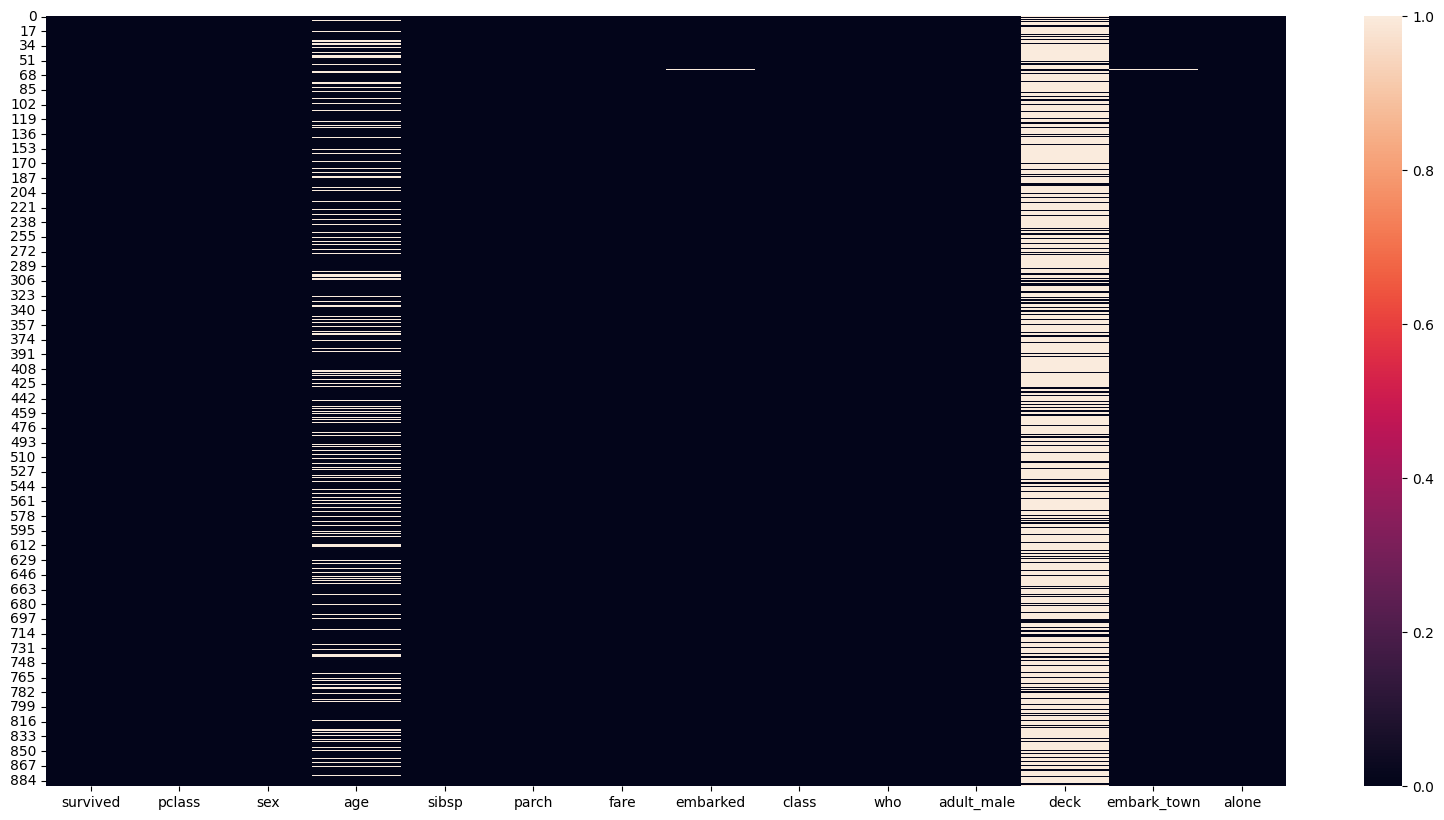

In [76]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna())

In [77]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
alone          0.000000
dtype: float64

## Analyse du Fond
### 1. Visulation initiale - Elimination des colonnes inutiles

In [78]:
df = df.reset_index(drop=True)

### Examination of the target column

In [79]:
df['survived'].value_counts(normalize=True)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

### Histograms of continuous variables

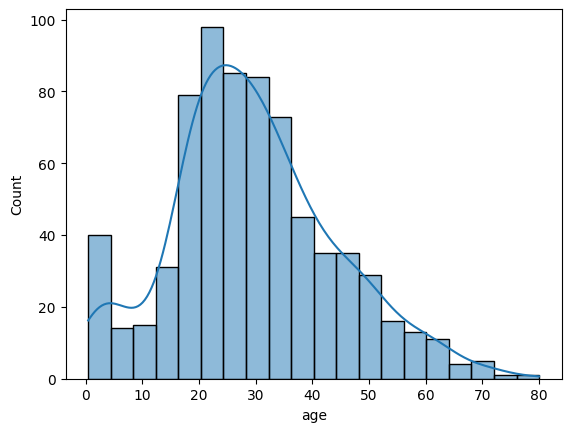

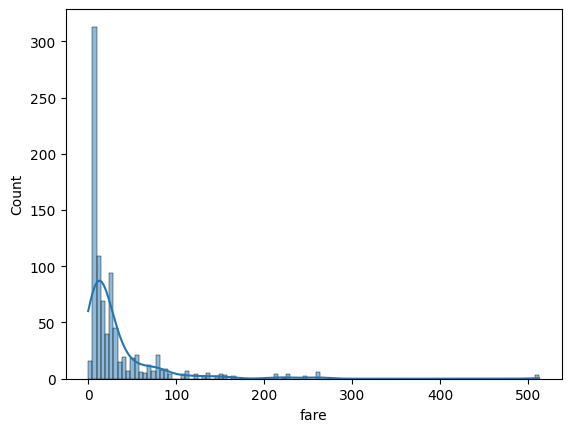

In [80]:
for col in df.select_dtypes(include='float'): 
    plt.figure()
    sns.histplot(df[col], kde=True)

### Object features

In [81]:
categorical_cols = [col for col in df.select_dtypes(exclude=np.number)]
categorical_cols


['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alone']

In [82]:
freq_tables = {
    col: pd.concat(
        [df[col].value_counts(), df[col].value_counts(normalize=True)],
        axis=1, keys=["count", "percent"]
    )
    for col in categorical_cols
}
for col, table in freq_tables.items():
    print(f"\n{col} frequencies:")
    display(table)


sex frequencies:


,count,percent
sex,,
male,577,0.647587
female,314,0.352413



embarked frequencies:


,count,percent
embarked,,
S,644,0.724409
C,168,0.188976
Q,77,0.086614



class frequencies:


,count,percent
class,,
Third,491,0.551066
First,216,0.242424
Second,184,0.206510



who frequencies:


,count,percent
who,,
man,537,0.602694
woman,271,0.304153
child,83,0.093154



adult_male frequencies:


,count,percent
adult_male,,
True,537,0.602694
False,354,0.397306



deck frequencies:


,count,percent
deck,,
C,59,0.290640
B,47,0.231527
D,33,0.162562
E,32,0.157635
A,15,0.073892
F,13,0.064039
G,4,0.019704



embark_town frequencies:


,count,percent
embark_town,,
Southampton,644,0.724409
Cherbourg,168,0.188976
Queenstown,77,0.086614



alone frequencies:


,count,percent
alone,,
True,537,0.602694
False,354,0.397306


## Relationship between the target and the variables
### Création des sous-ensembles survivants et morts

In [83]:
survivor_subset = df[df['survived']==1] 
non_survivor_subset = df[df['survived']==0] 


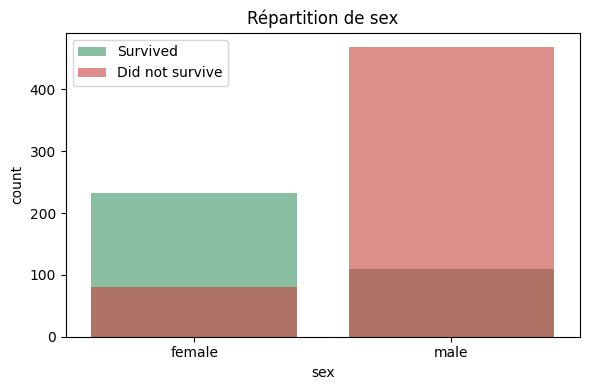

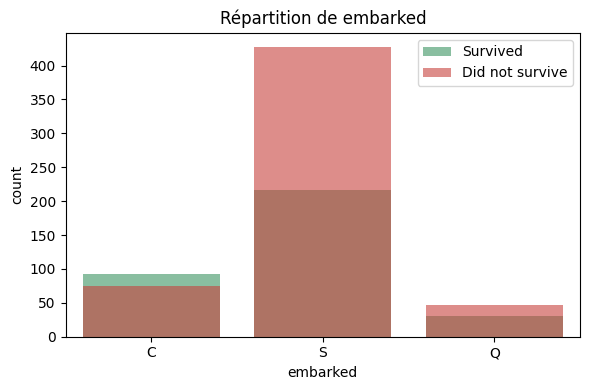

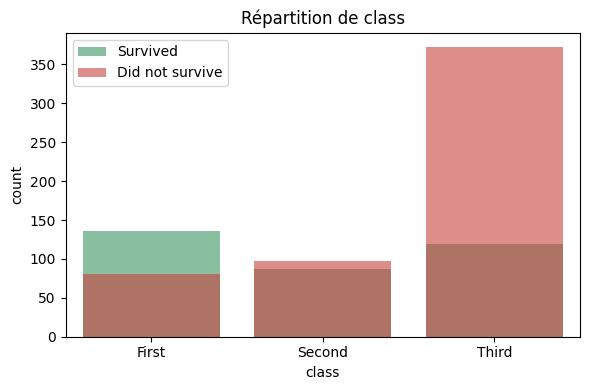

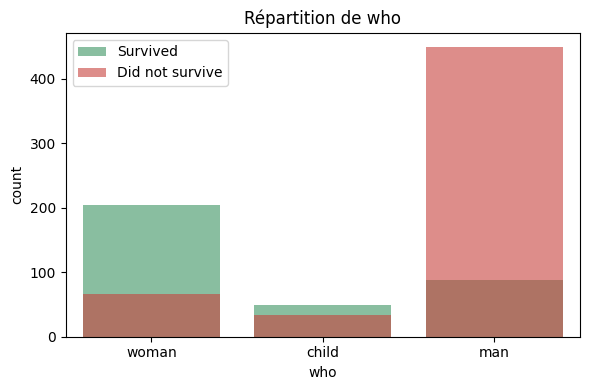

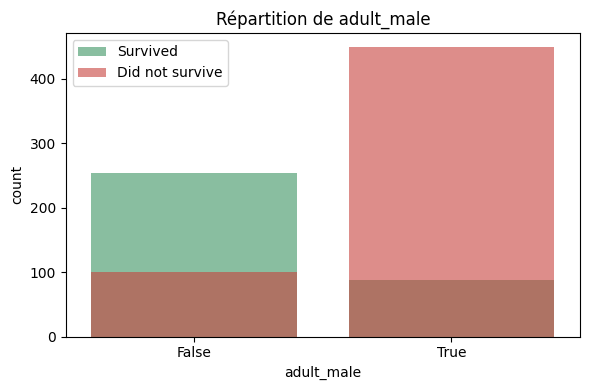

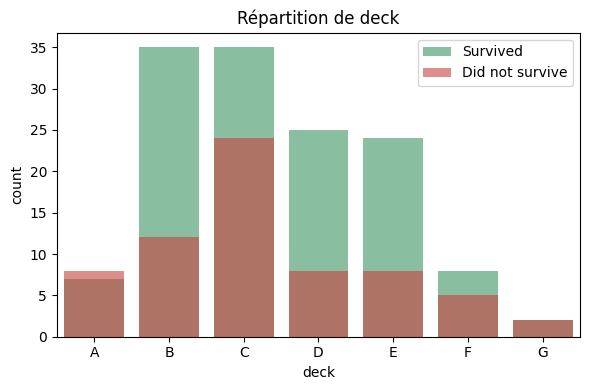

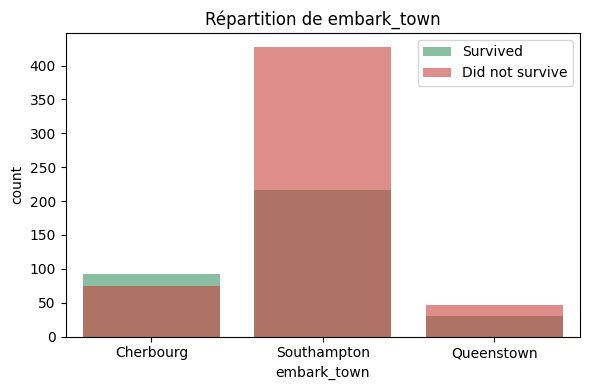

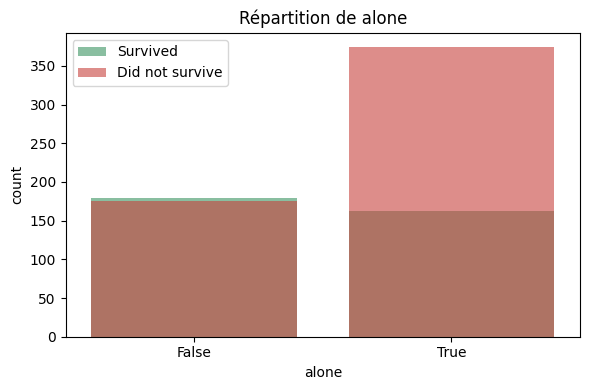

In [84]:
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=survivor_subset[col], color="#2ca25f", alpha=0.6, label="Survived")
    sns.countplot(x=non_survivor_subset[col], color="#de2d26", alpha=0.6, label="Did not survive")
    plt.title(f"Répartition de {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Relation Target / alone

In [85]:
pd.crosstab(df['alone'], df['survived'], normalize='index')

survived,0,1
alone,,
False,0.494350,0.505650
True,0.696462,0.303538


Donc si vous étiez accompagné vous aviez 50.6% de chance de survivre.

### Relation target / variables object


In [86]:
for col in [c for c in categorical_cols if c != "survived"]:
    ct = pd.crosstab(df[col], df['survived'], normalize="index")
    print(f"\nProportion de survie par {col}:")
    display(ct)


Proportion de survie par sex:


survived,0,1
sex,,
female,0.257962,0.742038
male,0.811092,0.188908



Proportion de survie par embarked:


survived,0,1
embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957



Proportion de survie par class:


survived,0,1
class,,
First,0.370370,0.629630
Second,0.527174,0.472826
Third,0.757637,0.242363



Proportion de survie par who:


survived,0,1
who,,
child,0.409639,0.590361
man,0.836127,0.163873
woman,0.243542,0.756458



Proportion de survie par adult_male:


survived,0,1
adult_male,,
False,0.282486,0.717514
True,0.836127,0.163873



Proportion de survie par deck:


survived,0,1
deck,,
A,0.533333,0.466667
B,0.255319,0.744681
C,0.406780,0.593220
D,0.242424,0.757576
E,0.250000,0.750000
F,0.384615,0.615385
G,0.500000,0.500000



Proportion de survie par embark_town:


survived,0,1
embark_town,,
Cherbourg,0.446429,0.553571
Queenstown,0.610390,0.389610
Southampton,0.663043,0.336957



Proportion de survie par alone:


survived,0,1
alone,,
False,0.494350,0.505650
True,0.696462,0.303538


### Relation de target / Age

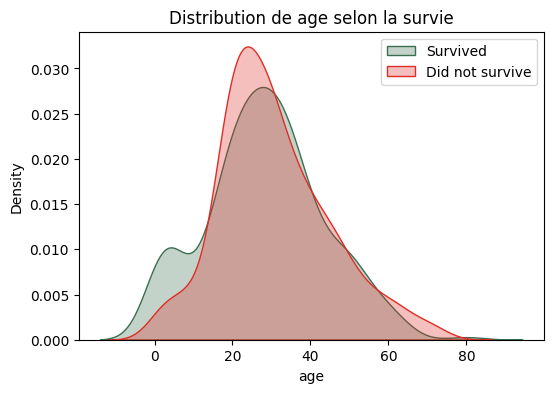

In [87]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(survivor_subset['age'].dropna(), ax=ax, color="#3a6f51", label="Survived", fill=True, alpha=0.3)
sns.kdeplot(non_survivor_subset['age'].dropna(), ax=ax, color="#de2d26", label="Did not survive", fill=True, alpha=0.3)
ax.set_title("Distribution de age selon la survie")
ax.legend()
plt.show()


### Relation target / variable quantitative

In [88]:
numerical_cols = df.select_dtypes(include='number').columns.difference(['age', 'survived', 'pclass'])


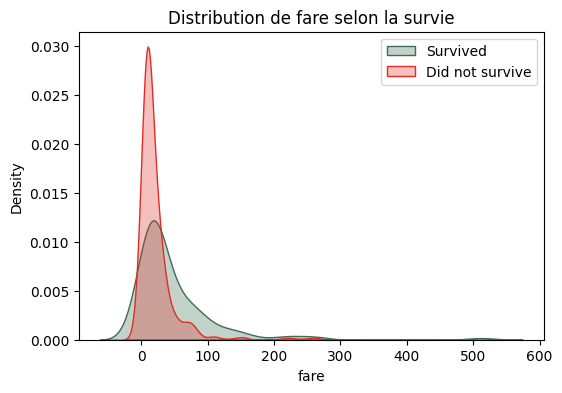

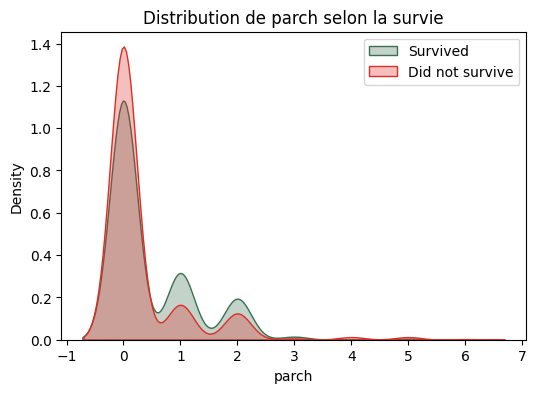

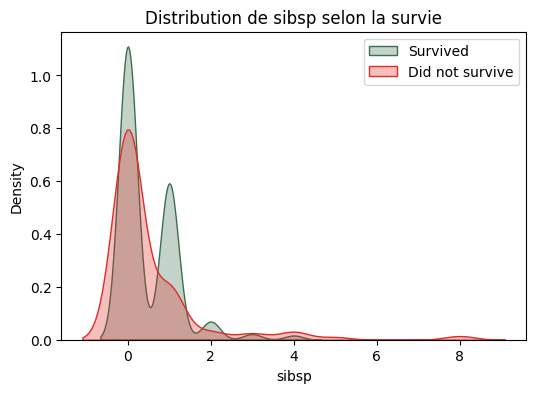

In [89]:
for col in numerical_cols:
     fig, ax = plt.subplots(figsize=(6, 4))
     sns.kdeplot(survivor_subset[col].dropna(), ax=ax, color="#3a6f51", label="Survived", fill=True, alpha=0.3)
     sns.kdeplot(non_survivor_subset[col].dropna(), ax=ax, color="#de2d26", label="Did not survive", fill=True, alpha=0.3)
     ax.set_title(f"Distribution de {col} selon la survie")
     ax.legend()
     plt.show()




In [90]:
pd.crosstab(df['parch'], df['survived'], normalize='index')

survived,0,1
parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000


## Heatmap avec corrélations

<Axes: >

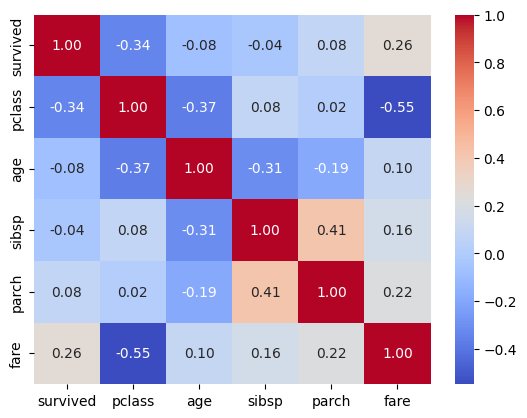

In [91]:
num_cols = df.select_dtypes(include='number').columns
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")


In [92]:
cat_cols = df.select_dtypes(exclude="number").columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

corr = df_encoded.corr()['survived'].sort_values(ascending=False)
print(corr.head(10))

survived        1.000000
who_woman       0.506562
fare            0.257307
deck_B          0.175095
deck_D          0.150716
deck_E          0.145321
deck_C          0.114652
class_Second    0.093349
parch           0.081629
deck_F          0.057935
Name: survived, dtype: float64


## Analyse un peu plus Avancée
### Relation Variables / Variables

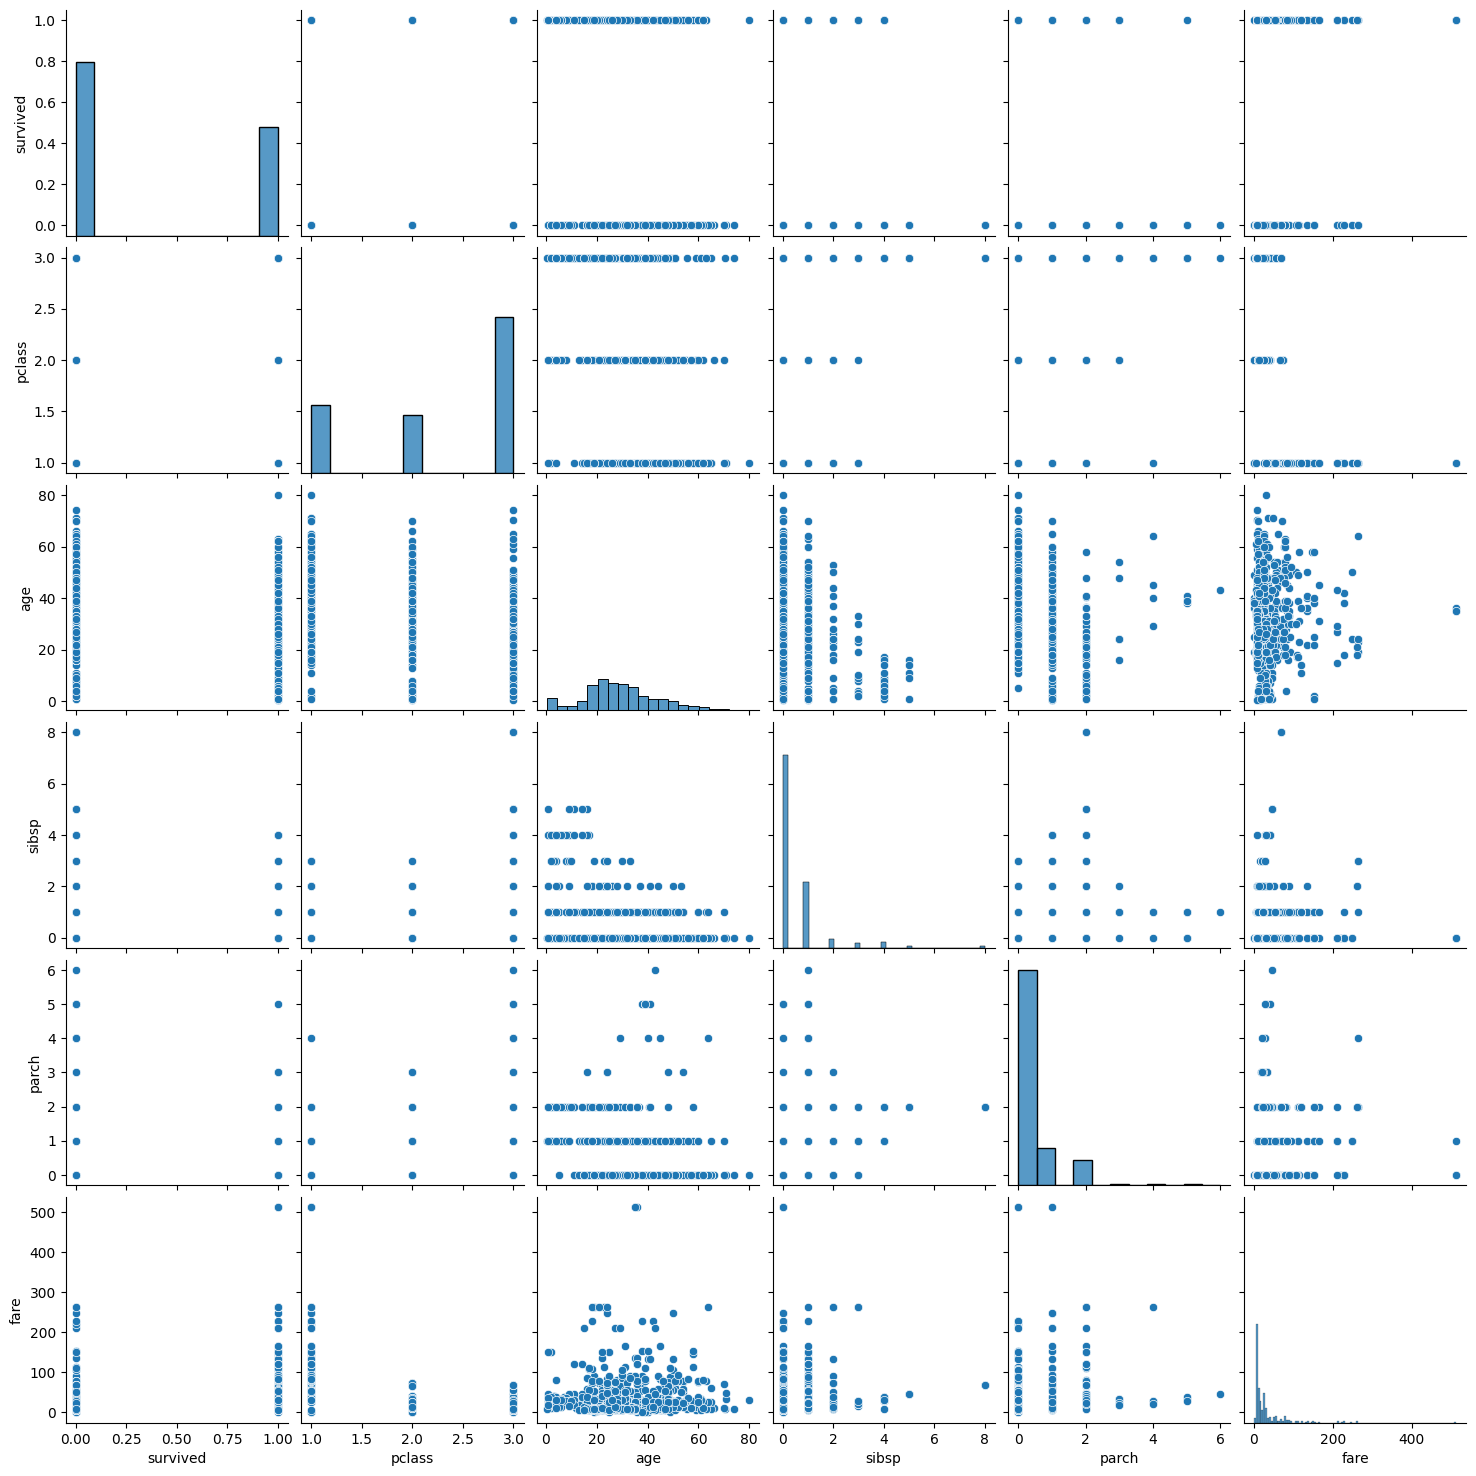

In [93]:
sns.pairplot(df[num_cols])

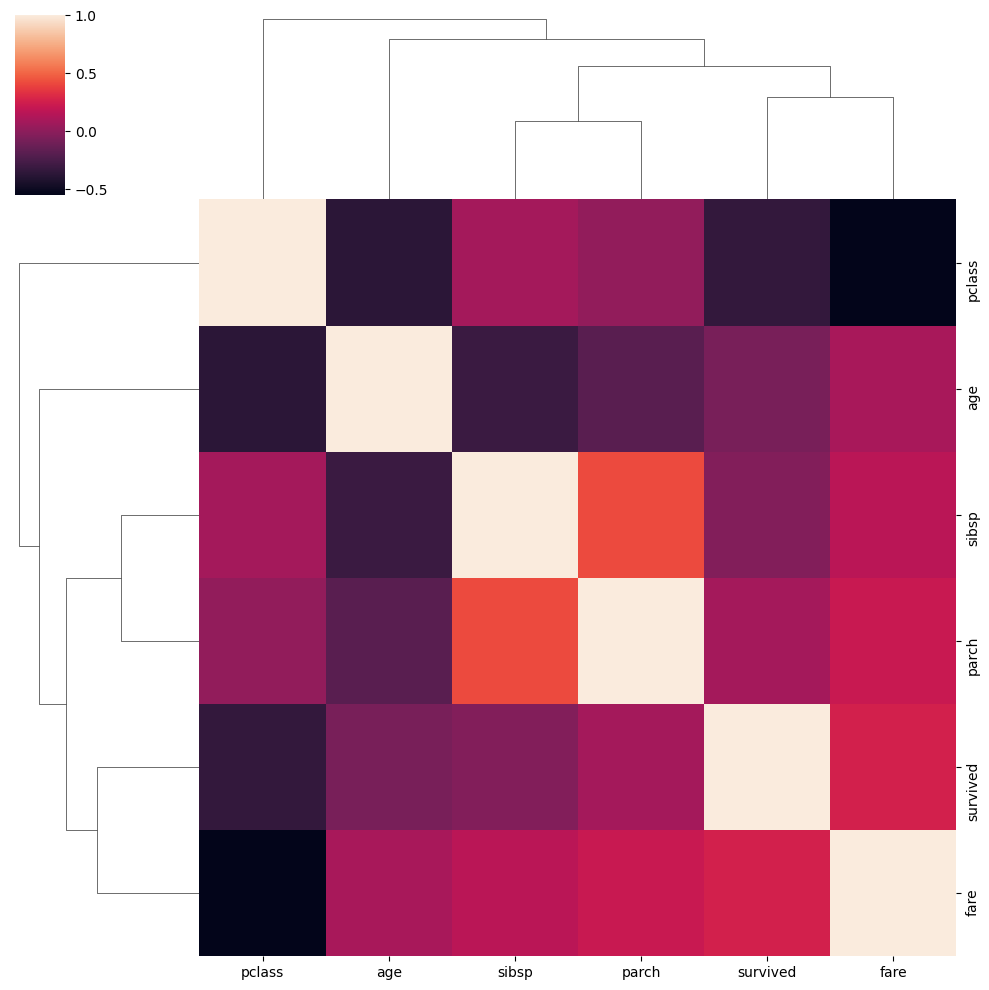

In [94]:
sns.clustermap(df[num_cols].corr())

### Relation entre age et Pclass

In [95]:
df.groupby('pclass')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


<Axes: xlabel='pclass', ylabel='age'>

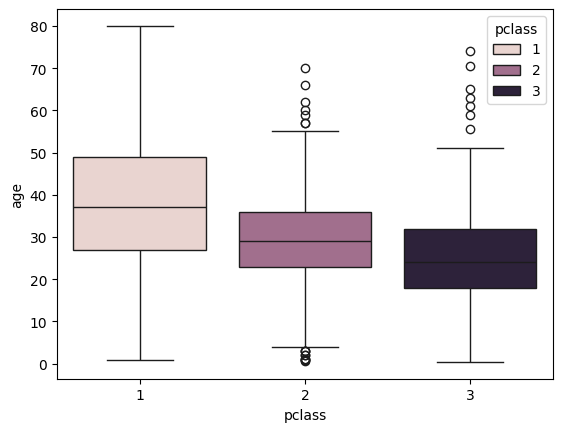

In [97]:
sns.boxplot(x='pclass', y='age', data=df, hue='pclass')

In [98]:
df[['pclass','age']].corr()

,pclass,age
pclass,1.000000,-0.369226
age,-0.369226,1.000000
